### Astrostatistics, University of Washington


# Week 6, Tuesday: Sampling and MCMC

##### Resources for this notebook include:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 5.  
- [Gordon Richard's notebooks](https://github.com/gtrichards/PHYS_T480)
- [Jake VanderPlas's workshop "Bayesian Astronomy"](https://github.com/jakevdp/BayesianAstronomy)
- [Jake VanderPlas's blog "Frequentism and Bayesianism: A Practical Introduction"](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)


##### Highly recommended supplemental background reading:
- [Thomas Wiecki: ``MCMC sampling for dummies by Thomas Wiecki"](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/)
  
##### For those who want to dive deep:
- [Andrieu et al. ``An Introduction to MCMC for Machine Learning" (includes a few pages of history)"](http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats, integrate
from scipy.stats import norm, cauchy
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


##  Markov Chain Monte Carlo

### Motivation

Consider the problem of estimating location and scale parameters
for a sample drawn from Gaussian distribution that we introduced earlier.
We had a two-dimensional posterior pdf for $\mu$ and $\sigma$:

![BayesSlide1](figures/Lgauss.jpg)

We obtained the marginalized pdfs by intergrating the two-dimensional
posterior over the other variable.

It was easy to numerically integrate the posterior pdf, as well 
as to find its maximum, using brute force grid search because
it was only a two-dimensional problem. With 100 grid points per
coordinate it was only $10^4$ values. However, even in a case
of rather simple 5-dimensional problem (as we'll discuss later 
today), we'd have $10^{10}$ values! And often we work with models 
of much higer dimensionality (it can be thousands!).

We need something better.

### Definition of the general problem

What we want to be able to do is to evaluate multi-dimensional 
($\theta$ is a k-dimensional vector) integrals of the form 

$$ I = \int g(\theta) \, p(\theta) \, d\theta,$$

where $g(\theta)$ is an arbitrary function and $p(\theta)$ is our posterior pdf:

$$ p(\theta) \equiv p(M,\theta \,|\,D,I) \propto p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I). $$

Where do such integrals appear? Everywhere. For example:

1) **Marginalization**: if the first $P$ elements of $\theta$ are the sought
after model parameters, and the next $k-P$ parameters are nuisance 
parameters, when marginalizing $p(\theta)$ over nuisance parameters
we have $g(\theta) = 1$ and we integrate over the space spanned by $k-P$ 
nuisance parameters. 

2) **Point estimates** for the posterior: if we want the mean of a model
parameter $\theta_m$, then $g(\theta) = \theta_m$ and we integrate over
all model parameters. 

3) **Model comparison**: to compute the Evidence, we set $g(\theta) = 1$ and integrate $p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I)$ over all model parameters. 

In [2]:
def plotfun(f, xmin=0, xmax=1, npts=1000):
    x = np.linspace(xmin, xmax, npts)
    plt.figure(figsize=(14, 8))
    plt.plot(x, f(x))

## Towards Efficient Integration Techniques

Assume we have a function we wish to integrate.

To make things concrete, let's use the [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution):

$$ p(x\mid\mu,b) = \frac{1}{2b} \exp \left(-\frac{|x-\mu|}b \right) $$

In [3]:
from scipy.stats import laplace
plotfun(laplace.pdf, -10, 10)

## Integration: Analytic

Analytically integrating the Laplace distribution function gives us:

$$
I(x) = \int^x p(x') dx' =
\begin{cases}
  \frac{1}{2} \exp \left( \frac{x-\mu}{b} \right) & \text{if }x \leq \mu \\[8pt]
  1-\frac{1}{2} \exp \left( -\frac{x-\mu}{b} \right) & \text{if }x \geq \mu
\end{cases}
$$

and now we can compute any definite integral as:

$$
\int_{x_{min}}^{x_{max}} p(x') dx' = I(x_{max}) - I(x_{min})
$$

Let's compute the integral between $(-2, 2)$:

In [4]:
def I(x, mu=0, b=1):
    if x < mu:
        return     0.5*np.exp( (x - mu) / b)
    else:
        return 1 - 0.5*np.exp(-(x - mu) / b)
    
    return y

I(2) - I(-2)

0.8646647167633872

## Integration: Numerical

We can also integrate this function numerically using the [rectangle rule](https://en.wikipedia.org/wiki/Riemann_sum):

$$
\{ x_j \} = \{ x_0 + 0.5 \Delta x, x_0 + 1.5 \Delta x, ... , x_0 + (N-0.5) \Delta x \}
$$

$$
\int_{x_{min}}^{x_{max}} p(x') dx' \approx  \Delta \, \sum_{j=1}^N p(x_j).
$$

where $\{ x_j \}$ are a series of values evenly spread over the $(x_{min}, x_{max})$ integration interval, spaced $\Delta$ apart.

We approximate the area under the $p(x)$ curve by a series of $\Delta$-wide rectangles whose areas we sum. The narrower the rectangles, the better the approximation.

In [5]:
# try changing dx and observe how the precision changes
xmin, xmax, dx = -2, 2, 0.25
x = np.arange(xmin+0.5*dx, xmax, dx)
y = laplace.pdf(x)

plotfun(laplace.pdf, xmin, xmax)
plt.gca().bar(x, y, align='center', width=dx, alpha=0.3);

print(np.sum(y*dx))

0.8624170836963213


## Integration: Sampling

Note how the rectangles from the Riemann sum of $p(x)$ are very reminiscent of histograms of samples drawn from $p(x)$ (with appropriate normalization).

We could construct them from a sample!

In [6]:
np.random.seed(42)

# compute the rectangles from samples
N = 10_000
xi = laplace.rvs(size=N)

# compute the histogram ("rectangle heights")
xmin, xmax, dx = -2, 2, 0.25
x = np.arange(xmin, xmax+dx, dx)
counts, bins = np.histogram(xi, bins=x)
x = bins[:-1] + dx/2
y = counts / N / dx

# sum up the rectangles
print(np.sum(y*dx))

plotfun(laplace.pdf, xmin, xmax)
plt.gca().bar(x, y, align='center', width=dx, alpha=0.3);

0.8632


That seems to work reasonably well!

## Integration: Sampling

Let's look at the math of what we've done above. We've replaced the computed PDF values, $p(x)$, with their estimates from histogram counts:

$$
I \approx \sum_{x_{min} < \,bin\,j\, < x_{max}} \left( \frac{h_j}{N \cdot dx} \right) \cdot dx = \frac{1}{N} \sum_{x_{min} < \,bin\,j\, < x_{max}} h_j
$$

where $h_j$ is the number of samples that fell into bin $j$.

Notice that $h_j$ can be formally written as:

$$
h_j = \sum_{x_i \, \in \, {\rm bin}_j} 1
$$

i.e. counting how many elements are in bin $j$ can be thought of as a sum where each sample $x_i$ that's in bin $j$ contributes with a weight of 1. It then follows that the sum:

$$
\sum_{x_{min} < \,bin\,j\, < x_{max}} h_j = \sum_{x_{min} < \,bin\,j\, < x_{max}} \sum_{x_i \, \in \, {\rm bin}_j} 1 = N(x_{min} < x_i < x_{max})
$$

is just the total count of samples that fell into all bins covering our integration interval, and we can therefore write:

$$
I \approx \frac{1}{N} \sum_{x_{min} < bin < x_{max}} h_j = \frac{N({x_{min} < x_i < x_{max})}}{N}
$$

where $N({x_{min} < x_i < x_{max}})$ is the number of samples ${x_i}$ within the integration bounds.

**Conclusion: if we have a sample drawn from a PDF (normalized to 1!), we can numerically approximate any integral of that PDF with a simple ratio of the number of samples that fell within the integration boundaries, vs. the total number of samples drawn!**:

$$
I \approx \frac{N({\rm within \, bounds)}}{N}
$$

This is true for arbitrarily complex functions, as well as multivariate functions.

Let's just check that the above holds for our example:

In [7]:
np.random.seed(42)

N = 10000
xi = laplace.rvs(size=N)

xmin, xmax, dx = -2, 2, 0.25
N_inside = len(xi[(xmin <= xi) & (xi <= xmax)])
N_inside / N

0.8632

Notice how easy this was to calculate!

## Integration: Computing Expected Values

What if we have an integral such as:

$$
I = \int_{x_{min}}^{x_{max}} g(x) \, p(x) \, dx
$$

, and we have the sample from $p(x)$?

That would be equivalent to estimating $p(x)$ from the sample as before (histogramming), but before summing up the estimates we multiply each one by $g(x)$ for that bin:

$$
    I = \int g(x) \, p(x) \, dx \approx \sum_{bins} g(x_j) \cdot \left( \frac{h_j}{N \cdot dx} \right) \cdot dx = \frac{1}{N} \sum_{bins} g(x_j) \cdot h_j 
$$

where $x_j$ is the center of each bin, and $h_j$ is the number of samples in that bin.

As before, notice that each $h_j$ can be formally written as:

$$
h_j = \sum_{x_i \, \in \, {\rm bin}_j} 1
$$

i.e. counting how many elements are in bin $j$ can be thought of as a sum where each sample $x_i$ that's in bin $j$ contributes with a weight of 1.

We can then write for any bin $j$:

$$
g(x_j) \cdot h_j = \sum_{x_i \, \in \, {\rm bin}_j} 1 \cdot g(x_j) \approx \sum_{x_i \, \in \, {\rm bin}_j} 1 \cdot g(x_i) = \sum_{x_i \, \in \, {\rm bin}_j} g(x_i)
$$

where we've replaced $x_j$ (the coordinate of the center of the bin) with $x_i$ the value of the samples within the bin because we assume the bins are small and all $x_i$ within a bin are similar in value to $x_j$.

If we now insert that back into the original formula, we discover it's just:

$$
I \approx \frac{1}{N} \sum_{bins} g(x_j) \cdot h_j = \frac{1}{N} \sum_{bins} \sum_{x_i \, \in \, {\rm bin}_j} g(x_i) = \frac{1}{N} \sum_{x_{min} < x_i < x_{max}} g(x_i)
$$

That is, given N samples drawn from a PDF $p(x)$ within some interval (or, more generally, (hyper-)volume) $V$, the integral of the product of any function $g(x)$ and $p(x)$ can be approximated as:

$$
I = \int_V g(x) \, p(x) \, dx \approx \frac{1}{N} \sum_{x_i} g(x_i)
$$

The approximation gets better with increasing number of samples.

## Another example

Let's evaluate:

$$
\int_0^1 x(1-x) dx
$$

using this technique.
 
Notice we can also think of this integral as:

$$
\int_{-\infty}^{\infty} x(1-x) dx \cdot u(x|\mu=0.5, W=1)
$$

where $u$ is the uniform (top-hat) distribution spanning the (0, 1) interval.

So we'll follow the prescription:
1. draw samples from a uniform distribution,
1. evaluate the value of the function for each sample, and
1. average the result

In code:

In [8]:
np.random.seed(42)

def myFunction(x):
    return x*(1-x)

I0 = 1.0/6   # true value 
for N in [10, 100, 1000, 10000, 100000]:
    theta = stats.uniform(0, 1).rvs(N)
    values = myFunction(theta)
    I = np.average(values)
    err = (I-I0)/I0
    print(f'N: {N:6},   I:{I: .5f},   err: {100*err: .3f}%')

N:     10,   I: 0.15980,   err: -4.120%
N:    100,   I: 0.16224,   err: -2.656%
N:   1000,   I: 0.16348,   err: -1.910%
N:  10000,   I: 0.16771,   err:  0.624%
N: 100000,   I: 0.16681,   err:  0.088%


This is excellent!

It means that, given a sample, we can very easily (approximately) compute any integral of the form above, if we just have a sample drawn from $p(x)$!

This is an example of **Monte Carlo integration**.

## Monte Carlo Methods
 

![monaco](figures/monacoMap.jpg)
![monaco](figures/montecarlophoto.jpg)


Monte Carlo is a city in Europe, in the Principality of Monaco
and they are known for gambling. A family of random sampling methods was named
after Monte Carlo in order to keep the method secret [\*] (because it was invented and
used for nuclear weapons design in the U.S. after World War II). With 
the advent of computers, Monte Carlo methods, such as Monte Carlo integration and 
Monte Carlo statistical tests, became hugely important. 

[\*] Note: this is an _awful_ codename. Leaks information.

The modern version of the Markov Chain Monte Carlo method was invented in the late 1940s by Stanislaw Ulam, while he was working on nuclear weapons projects at the Los Alamos National Laboratory. The name Monte Carlo
was given to the method by Nick Metropolis, who then invented the Metropolis sampler, which evolved into
one of the most famous MCMC algorithms, the Metropolis-Hastings algorithm. 

Algorithms for generating Markov chains are numerous and greatly vary in complexity
and applicability. Many of the most important ideas were generated in physics, especially
in the context of statistical mechanics, thermodynamics, and quantum field theory.

## Advantages

Solving integrals of the form:

$$ I = \int_V g(\theta) \, p(\theta) \, d\theta,$$

via sampling has two key advantages over grid-based methods (i.e., the rectangle rule):

1. The number of grid points on which we'd have to compute $p(\theta)$ and $g(\theta)$ explodes as the number of dimensions (i.e., the number of variables) grows. Sampling is *much* less sensitive to this. We can approximate even million-dimensional integrals!

2. Unless you already know something about $p(\theta)$, grid integration may spend much of its time in areas where the integrand is close to zero and doesn't contribute much to the integral. Integrating by sampling from $p(x)$ avoids this, making the computation much more efficient.

## Example

In [9]:
def twoD_gauss_with_grid():
    import numpy as np
    from matplotlib import pyplot as plt
    from matplotlib.patches import Ellipse
    from astroML.stats.random import bivariate_normal

    mean = np.array([0, 0])
    sigma_1 = 2
    sigma_2 = 1
    alpha = np.pi / 4

    #------------------------------------------------------------
    # Draw 10^5 points from a multivariate normal distribution
    #
    np.random.seed(0)
    x, cov = bivariate_normal(mean, sigma_1, sigma_2, alpha, size=100_000,
                              return_cov=True)

    sigma_x = np.sqrt(cov[0, 0])
    sigma_y = np.sqrt(cov[1, 1])
    sigma_xy = cov[0, 1]

    #------------------------------------------------------------
    # Plot the results
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    # plot a 2D histogram/hess diagram of the points
    H, bins = np.histogramdd(x, bins=2 * [np.linspace(-9, 9, 101)])
    ax.imshow(H, origin='lower', cmap=plt.cm.binary, interpolation='nearest',
              extent=[bins[0][0], bins[0][-1], bins[1][0], bins[1][-1]])

    # draw 1, 2, 3-sigma ellipses over the distribution
    for N in (1, 2, 3):
        ax.add_patch(Ellipse(mean, N * sigma_1, N * sigma_2,
                             angle=alpha * 180. / np.pi, lw=1,
                             ec='k', fc='none'))

    kwargs = dict(ha='left', va='top', transform=ax.transAxes)

    ax.text(0.02, 0.98, r"$\sigma_1 = %i$" % sigma_1, **kwargs)
    ax.text(0.02, 0.93, r"$\sigma_2 = %i$" % sigma_2, **kwargs)
    ax.text(0.02, 0.88, r"$\alpha = \pi / %i$" % (np.pi / alpha), **kwargs)

    ax.text(0.15, 0.98, r"$\sigma_x = %.2f$" % sigma_x, **kwargs)
    ax.text(0.15, 0.93, r"$\sigma_y = %.2f$" % sigma_y, **kwargs)
    ax.text(0.15, 0.88, r"$\sigma_{xy} = %.2f$" % sigma_xy, **kwargs)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    import matplotlib.ticker as plticker
    loc = plticker.MultipleLocator(base = float(bins[0][1]-bins[0][0]))
    plt.gca().xaxis.set_minor_locator(loc)
    plt.gca().yaxis.set_minor_locator(loc)

    plt.grid(b=True, which='minor')

    plt.show()

/Users/ajc/miniconda3/envs/developer/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


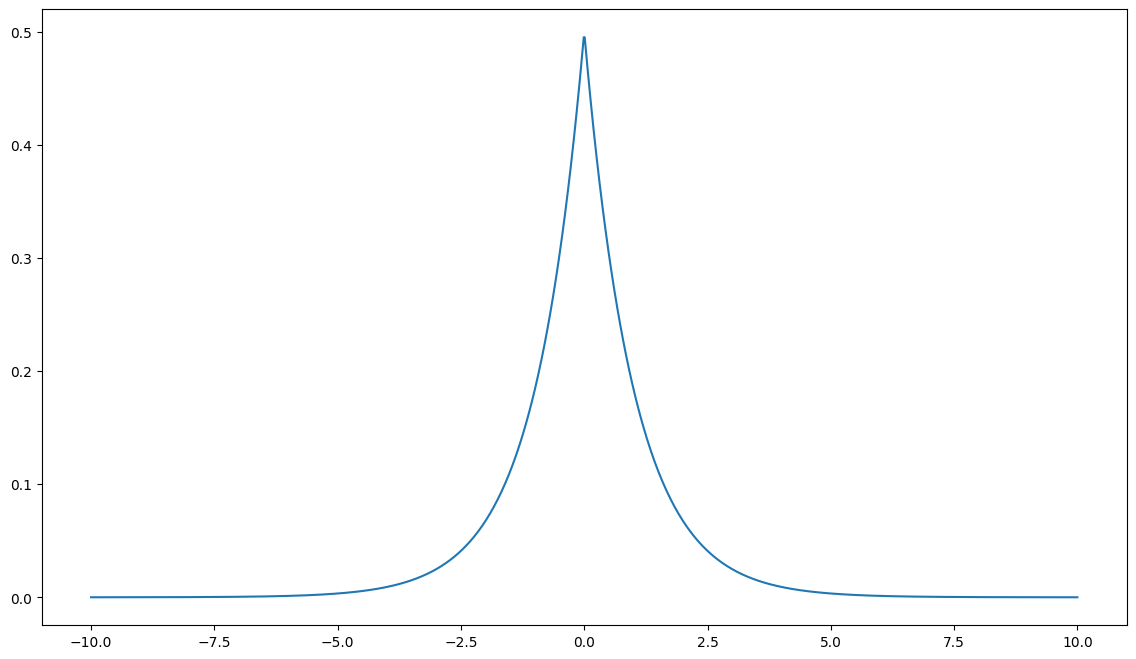

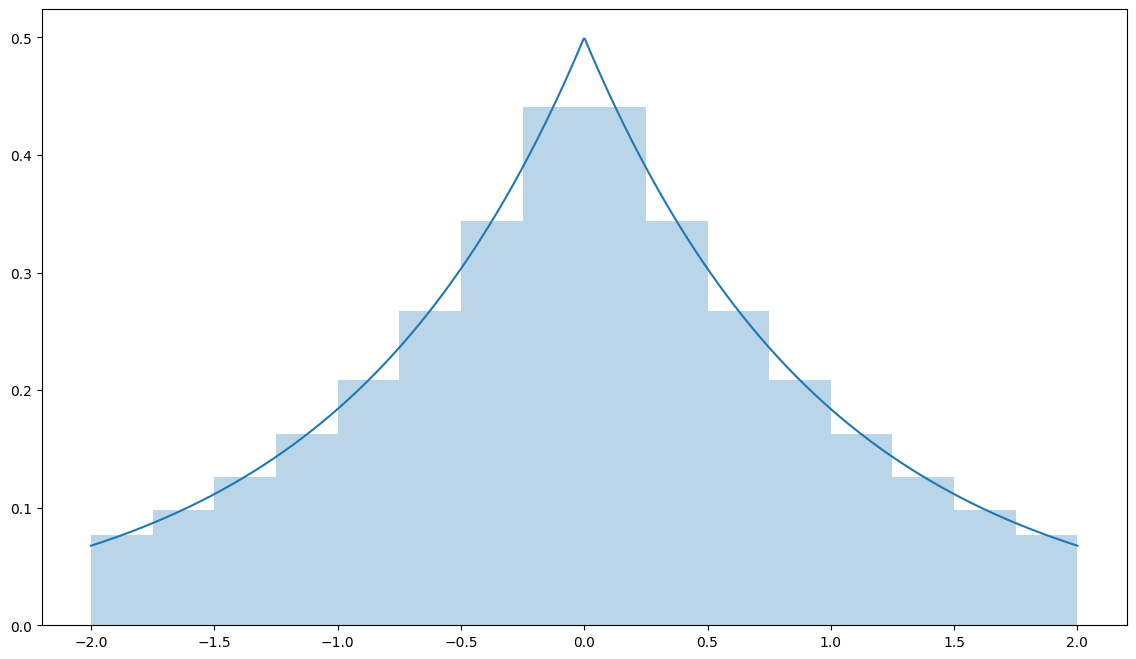

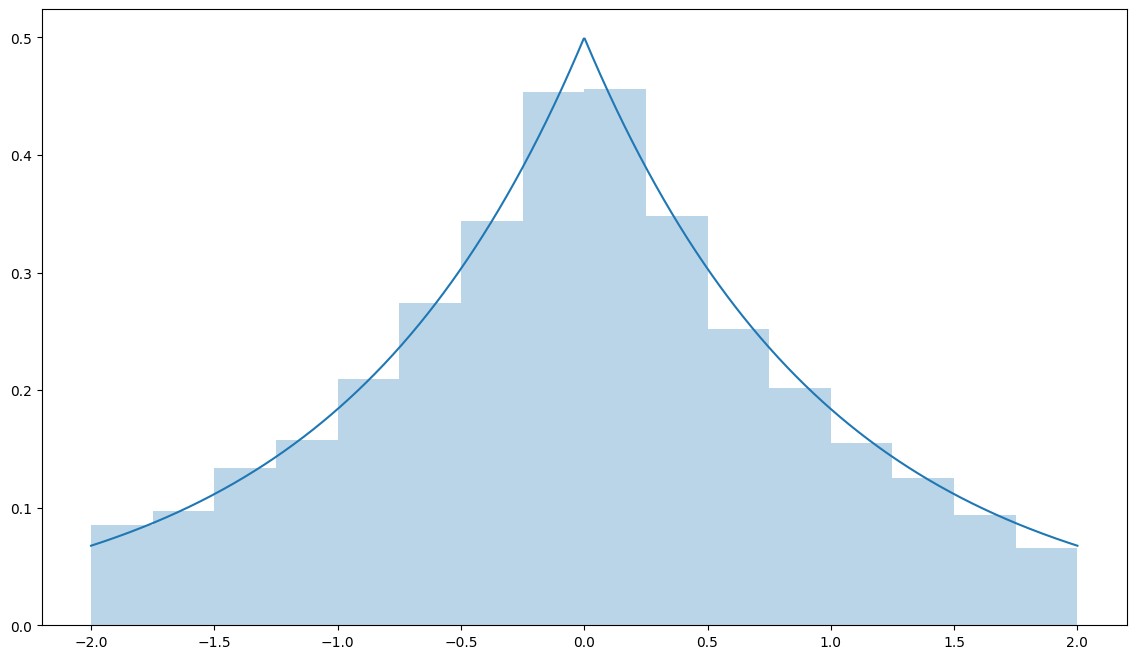

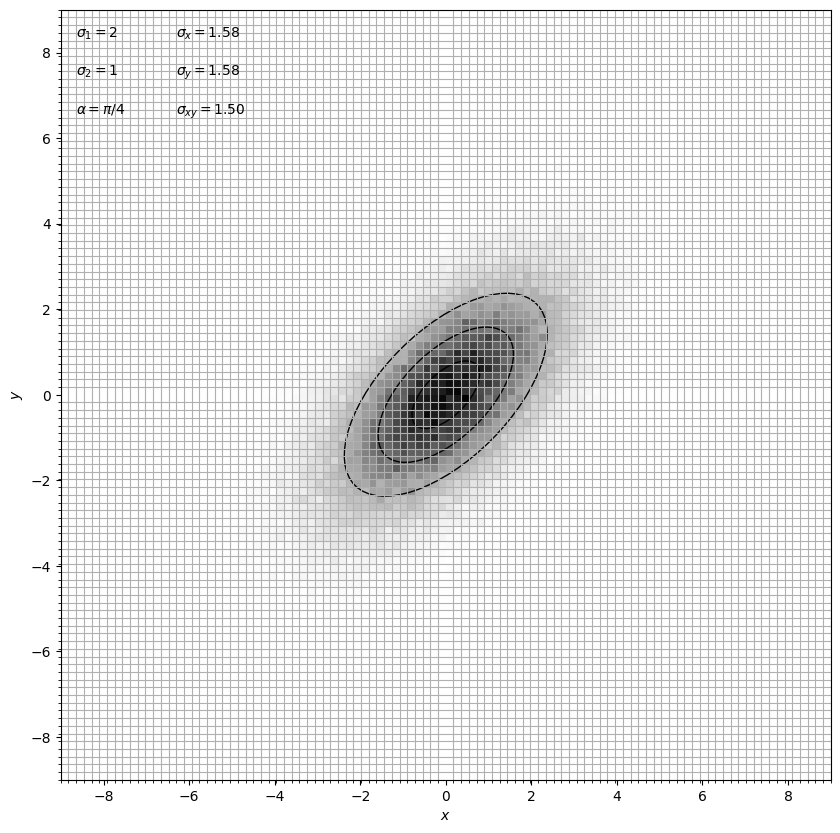

In [10]:
twoD_gauss_with_grid()

The image above has the same number of samples (which were binned and visualized as the image) and grid points.

Notice how nearly all of the grid points are outside of the area where $p(x)$ is appreciably different from zero. If we computed an integral, less than $\sim 10\%$ of points would cover the area that actually contributes appreciably to the sum.

Contrast this to sampling from $p(x)$, where nearly all samples are concentrated in the area where the value of $p(x)$ is relatively high (close to the center). This makes computing the integral from these points over 10x more more efficient (more accurate for the same amount of work) than doing it on a grid!

This difference becomes even more drammatic as the dimensionality of the problem grows (e.g., imagine what this would look like in 3D, 4D, etc..).

## Representing posteriors with samples

Remember that a posterior is some (potentially highly-dimensional) function:

$$
p(\theta|D) \propto p(D|\theta) p(\theta)
$$

In specific cases it can be written down analytically (e.g, the 2D gaussian above), but in the general case it can't and we'd have to tabulate it's values on a (large) grid.

The ability to compute integrals from samples gives us another, more efficient, way of recording the posterior: **instead of tabulating on a (potentially extremely large) grid, sample it and write down that sample.**

This sample can then be used to compute all integrals of interest. It can also be histogrammed when we want to visualize the posterior (the prior 2D Gaussian plot is an example of that). **For practical purposes, it becomes our posterior.**

## Technical problem: Normalizing the Posterior

Excellent! So how do we draw a sample from an (arbitrary) posterior?

This is where we encounter a technical problem. We obtain posteriors by the application of the Bayes rule. And while it's easy to compute a function **proportional** to the posterior:

$$
p(\theta|D) \propto p(D|\theta) p(\theta)
$$

, its normalization constant (the integral) is generally unknown.

While we haven't discussed it, most algorithms that draw samples from some $p(x)$ rely on the knowledge of the integral of $p(x)$ to do so. That's how the various `.rvs` functions in `scipy` are implemented.

So we have a chicken-and-an-egg problem:
  * To draw samples from the unnormalized $p(x)$ with common algorithms, we need to know its integral.
  * To efficiently compute the integral of the unnormalized $p(x)$, we need to draw samples from it!

Question: Are there methods that can draw samples from some $p(x)$, but which will not require the knowledge of the integral of $p(x)$?

##  Markov Chains

Yes. A family of sampling procedures known as ***Markov Chain Monte Carlo*** allows us to do this.

A **Markov Chain** is a sequence of random variables where a given value directly depends only on its preceding value. That is, imagine I draw samples one by one. If I've just drawn a value $\theta_{i}$, the probability to draw some $\theta_{i+1}$ will only explicitly depend on $\theta_{i}$, my current value, and not on any prior values. I.e., I don't have memory of the past; decisions are based solely on where I am in the present. A random walk (Brownian motion) is an example of a Markov process.

**A feature of Markov processes is that they can generate samples from distributions whose integral/normalization is unknown.** Given a function proportional to $p(\theta)$, MCMC returns a sample of points, or **"chain"**, from the k-dimensional parameter space, with  a distribution that is **asymptotically proportional** to $p(\theta)$.

## MCMC at a High Level: Walkers

Algorithms for generating Markov chains are numerous and greatly vary in complexity and applicability. **We will only describe them here at a very high level, and mostly focus on their usage via Python libraries.**

Most MCMC algorithms have in common the concept of a **walker** -- an imaginary entity moving through the space that's being sampled. The walker starts at some random point of the parameter space. Its motion occurs as a sequence of steps, and the set of positions where the walker is at each step forms the sample -- the **Markov chain**.

What are the rules of motion? At each step $i$, the walker is at $\theta_i$, chooses a potential new spot to move to $\theta_{i+1}^{proposed}$, and decides whether to move there based on the **transition probability**:

$$ T(\theta_{i+1}^{proposed}|\theta_i) $$

$T(\theta_{i+1}^{proposed}|\theta_i)$ is also called the **jump kernel** or **transition kernel**, and the $p(\theta_i)$ is our unnormalized posterior. Various MCMC algorithms mainly differ in their choice of transition kernel.

##  Markov Chain Monte Carlo

**The Metropolis-Hastings algorithm** adopts the kernel

$$  T(\theta_{i+1}\,|\,\theta_i) =  p_{\rm acc}(\theta_i,\theta_{i+1}) \, K(\theta_{i+1}\,|\,\theta_i), $$

where the **proposal distribution** $K(\theta_{i+1}\,|\,\theta_i,)$ is an *arbitrary* function that specifies how big of a step a walker can make. A Gaussian distribution centered on $\theta_i$ is often used for $K(\theta_{i+1}|\theta_i)$.

The proposed point $\theta_{i+1}$ is then randomly accepted with the acceptance probability:

$$   p_{\rm acc}(\theta_i,\theta_{i+1}) = { K(\theta_i\,|\,\theta_{i+1}) \,  p(\theta_{i+1}) \over
                       K(\theta_{i+1}\,|\,\theta_i) \,  p(\theta_i) } $$

(when exceeding 1, the proposed point $\theta_{i+1}$ is always accepted). **When $\theta_{i+1}$ is rejected, $\theta_i$ is added to the chain instead.**

##  Markov Chain Monte Carlo

**In summary, the Metropolis-Hastings algorithm consists of these steps:**

1) given $\theta_i$ and $K(\theta_{i+1}|\theta_i)$, draw a proposed value for $\theta_{i+1}.$ The scale of $K(\theta_{i+1}|\theta_i)$ defines how big of a jump the walker could make.

2) compute acceptance probability $p_{\rm acc}(\theta_i,\theta_{i+1})$.

3) draw a random number between 0 and 1 from a uniform distribution; if it smaller than
   $p_{\rm acc}(\theta_i,\theta_{i+1})$ we accept $\theta_{i+1}$.
   
4) if $\theta_{i+1}$ is accepted, add it to the chain. If not, add $\theta_{i}$ (again) to the chain.

After many of these steps, our chain will form a sample from the distribution $p(\theta)$!

### Metropolis-Hastings Example

Estimating the value of $\mu$ for data (100 data points) drawn from a Gaussian distribution.

Approach #1 (classic):
* Compute likelihoods on a grid, multiply them to obtain the posterior, marginalize to obtain an estimate of $\mu$

Approach #2 (MCMC):
* Compute the Markov chain that is distributed like the posterior, marginalize to obtain an estimate of $\mu$

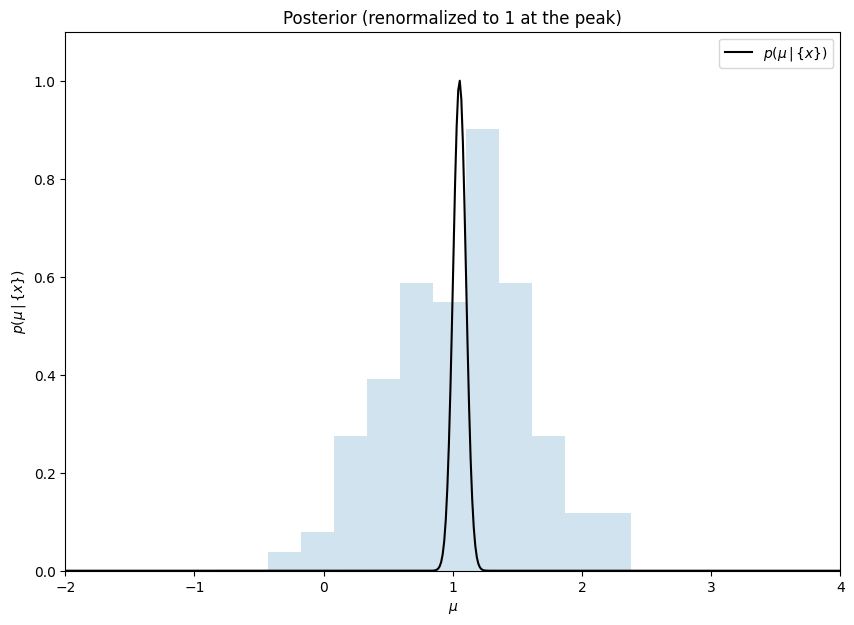

NOTE: Ndata= 100 sigmaData= 0.5 so sigma_mu= 0.05


In [11]:
np.random.seed(21)

def Likelihood(x,sigma, data):
    # Gaussian likelihood 
    return np.prod(np.exp(-(data-x)**2/2/sigma**2))

def Prior(x):
    return 1.0/10   # flat: it cancels out and has no effect 

def myPosterior(x, sigma, data):
    return Likelihood(x, sigma, data)*Prior(x)

## generate data
Ndata = 100
mu = 1.0
sigma = 0.5 # assumed known 
data = stats.norm(mu, sigma).rvs(Ndata)

# plot likelihood function 
muMin = mu - 6*sigma
muMax = mu + 6*sigma
muGrid = np.linspace(muMin, muMax, 500)
posterior = 0*muGrid

for j in range(0,np.size(muGrid)):
    posterior[j] = myPosterior(muGrid[j], sigma, data)

posteriorNorm = posterior/np.max(posterior)
# plot
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(muGrid, posteriorNorm, ls='-', c='black', label=r'$p(\mu\,|\,\{x\})$')
plt.hist(data, bins = 'auto', density=True, histtype = 'stepfilled', alpha=0.2)

plt.xlim(muMin, muMax)
plt.ylim(0, 1.1)
plt.xlabel('$\mu$')
plt.ylabel(r'$p(\mu\,|\,\{x\})$')
plt.title('Posterior (renormalized to 1 at the peak)')
plt.legend()
plt.show() 

sigMu = sigma/np.sqrt(Ndata)
print('NOTE: Ndata=', Ndata, 'sigmaData=', sigma, 'so sigma_mu=', sigMu)

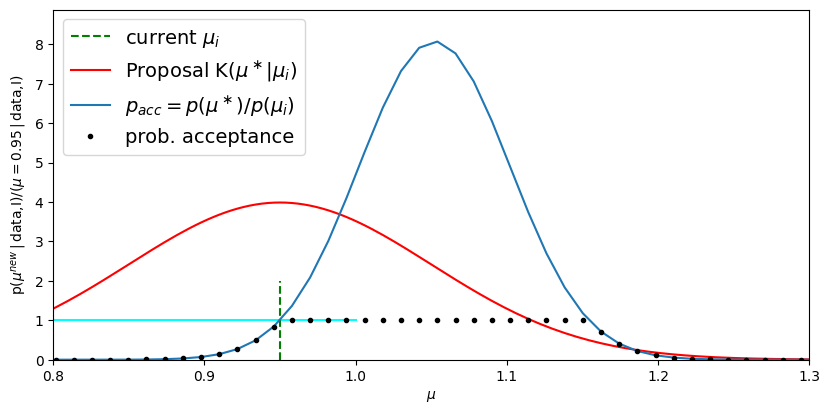

NOTE: we accept if a uniform random number (0-1) falls below the black dotted curve.


In [12]:
## illustrate Metropolis-Hastings algorithm 
muStart = 0.95
posteriorStart = myPosterior(muStart, sigma, data)
pRatio = posterior/posteriorStart

# plot 
fig = plt.figure(figsize=(9, 5))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.35, bottom=0.18)
ax0 = fig.add_subplot(111)
ax0.axis([0.8, 1.3, 0, 1.1*np.max(pRatio)])
plt.xlabel('$\mu$')
plt.ylabel('p($\mu^{new}\,|\,$data,I)/($\mu=0.95\,|\,$data,I)')
plt.plot([0.8,1.0],[1.0,1.0], '-', c='cyan')
plt.plot([0.95,0.95],[0.0,2.0], '--', c='green', label=r'current $\mu_i$')

# plot proposal distribution
muG = np.linspace(0.0, 2.0,500)
sigmaProp = 0.1
prop = norm(muStart, sigmaProp).pdf(muG) 
plt.plot(muG, prop, c='red', label=r'Proposal K($\mu^\ast|\mu_{i}$)')
plt.plot(muGrid, pRatio, label=r'$p_{acc}=p(\mu^\ast)/p(\mu_i)$')
plt.plot(muGrid[pRatio<1], pRatio[pRatio<1], '.', c='black',label=r'prob. acceptance')
plt.plot(muGrid[pRatio>1], 1+0*muGrid[pRatio>1], '.', c='black')
ax0.legend(loc=2, prop=dict(size=14))
plt.show() 

print('NOTE: we accept if a uniform random number (0-1) falls below the black dotted curve.')

In [13]:
## generate a chain using Metropolis-Hastings algorithm 

# Markov chain 
M = 5000  # the requested number of steps in the chain
chain = np.linspace(0,1,M)
chain[0] = 0.5 # starting position
Pold = myPosterior(chain[0], sigma, data)

# gaussian width for "jumping" from the current position
#    sigmaProp            Na   Nr   Np     
# sigmaProp = 0.03    #  3992 1007 1968   (high acc, long burn-in) 
# sigmaProp = 0.3     #  1043 3956  534   (low acc, short burn-in) 
sigmaProp = 0.10      #  2514 2485 1248        

Na = Nr = Np = 0
# and now sample M times
for i in range(1,M):
    # 1) generate a new value: a gaussian jump from current value
    Cold = chain[i-1]
    Cnew = stats.norm(Cold, sigmaProp).rvs(1)
    Pnew = myPosterior(Cnew, sigma, data)
    # 2) acceptance condition 
    Pratio = Pnew / Pold  
    if (Pratio > 1): 
        Np += 1   # just a counter, nothing else is done 
    # if we only accept Pratio>1, we'll get a hill-climbing algorithm
    # instead, we'll randomly accept this proposal with probability Pratio 
    randNumber = stats.uniform(0, 1).rvs(1)
    if (randNumber < Pratio):
        # accepting this new proposed value
        chain[i] = Cnew
        Pold = Pnew
        Na += 1
    else:
        # rejecting the proposed value and stickin' with the previous one 
        chain[i] = Cold
        Nr += 1
 
print('NNN(arp): ', Na, Nr, Np)

NNN(arp):  2514 2485 1248


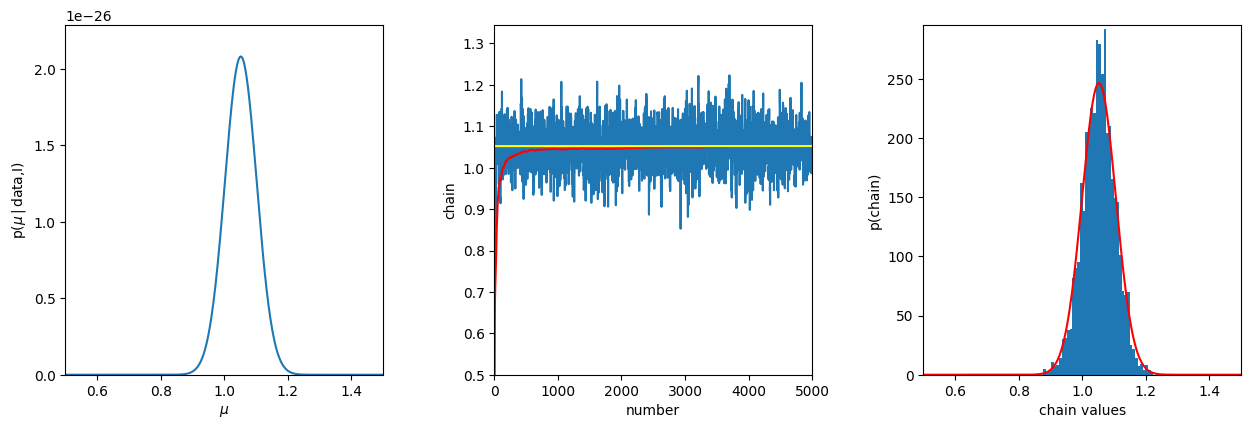

µ=1.052, 𝜎=0.053


In [14]:
# start plot 
fig = plt.figure(figsize=(14, 5))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.35, bottom=0.18)

ax0 = fig.add_subplot(131)
muGrid = np.linspace(mu-sigma,mu+sigma,500)
posterior = 0*muGrid
for j in range(0,np.size(muGrid)):
    posterior[j] = myPosterior(muGrid[j], sigma, data)
plt.plot(muGrid, posterior)
ax0.axis([mu-sigma, mu+sigma, 0, 1.1*np.max(posterior)])
plt.xlabel('$\mu$')
plt.ylabel('p($\mu\,|\,$data,I)')

ax1 = fig.add_subplot(132)
x = np.linspace(1,M,M)
plt.plot(x, chain)
ax1.axis([0, M, np.min(chain), 1.1*np.max(chain)])
plt.xlabel('number')
plt.ylabel('chain')
# plot running mean: 
meanC = [np.mean(chain[:int(N)]) for N in x]
ax1.plot(x, meanC,c='red') 
ax1.plot(x, 0*x+np.mean(data),c='yellow') 

ax2 = fig.add_subplot(133)
# skip first Nburn samples
Nburn = 1000
Nchain = np.size(chain[x>Nburn])
Nhist, bins, patches = plt.hist(chain[x>Nburn], bins = 'auto', histtype = 'stepfilled')
# plot expectations based on CLT
binwidth = bins[1]-bins[0]
muCLT = np.mean(data)
sigCLT = np.std(data)/np.sqrt(Ndata)
muGrid = np.linspace(mu-sigma,mu+sigma,500)
gauss = Nchain*binwidth*stats.norm(muCLT, sigCLT).pdf(muGrid) 
ax2.plot(muGrid, gauss, c='red') 
ax2.set_ylabel('p(chain)')
ax2.set_xlabel('chain values')
ax2.set_xlim(mu-sigma, mu+sigma)
ax2.set_ylim(0, 1.2*np.max(gauss))

plt.show()
print(f"µ={muCLT:.3f}, 𝜎={sigCLT:.3f}")

## Caveats

* Adjacent samples are correlated (not independent)! We'll see this when we go through a couple of examples.

* Although $K(\theta_{i+1}|\theta_i)$ satisfies a Markov chain requirement that it
must be a function of only the current position $\theta_i$, it takes a number
of steps to reach a stationary distribution from an initial arbitrary position $\theta_0$.
**These early steps are called the "burn-in" and need to be discarded in analysis.**
There is no general theory for finding transition from the burn-in phase to
the stationary phase; several methods are used in practice. Gelman and Rubin
proposed to generate a number of chains and then compare the ratio of
the variance between the chains to the mean variance within the chains (this
ratio is known as the $R$ statistic). For stationary chains, this ratio will
be close to 1.  

When the posterior pdf is multimodal, the simple Metropolis--Hastings algorithm can
become stuck in a local mode and not find the globally best mode within a reasonable
running time. There are a number of better algorithms, such as Gibbs sampling, parallel
tempering, various genetic algorithms, and nested sampling.



<img src="figures/Andrieu4.jpg" alt="Drawing" style="width: 600px;"/>